### step # 0: Download Dataset and preprocessing 

In [ ]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import csv
import cv2

tf.config.optimizer.set_jit(True)

##### Download Dataset
Run the codes of this section only one time, it will downlad and store the dataset in your drive

##### Mount your drive
First, mount your drive on this notebook. After running the next cell, you can see your google drive directory in Files, the left side of this page.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### Download cars images

In [ ]:
# !wget http://imagenet.stanford.edu/internal/car196/car_ims.tgz

--2021-01-10 17:33:43--  http://imagenet.stanford.edu/internal/car196/car_ims.tgz
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1956628579 (1.8G) [application/x-gzip]
Saving to: ‘car_ims.tgz’

car_ims.tgz         100%[===================>]   1.82G  20.6MB/s    in 76s     

2021-01-10 17:34:59 (24.5 MB/s) - ‘car_ims.tgz’ saved [1956628579/1956628579]



##### Download annotations

In [ ]:
# !gdown --id 1XJnWLShjrr47WI_yPCyKBGEWsAKjfnjS
# !gdown --id 19mQADQyu9z8hCdsgbIBn6naTv4uXyc0O
# !gdown --id 1mrFRxNcu_nZuTeWrSTaeBMblg9ZBWsQw

Downloading...
From: https://drive.google.com/uc?id=1XJnWLShjrr47WI_yPCyKBGEWsAKjfnjS
To: /content/annot_test.csv
100% 298k/298k [00:00<00:00, 86.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=19mQADQyu9z8hCdsgbIBn6naTv4uXyc0O
To: /content/annot_train.csv
100% 302k/302k [00:00<00:00, 42.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1mrFRxNcu_nZuTeWrSTaeBMblg9ZBWsQw
To: /content/class_names.csv
100% 5.45k/5.45k [00:00<00:00, 4.75MB/s]


##### Move to drive

In [ ]:
# !mkdir -p "/content/drive/My Drive/Datasets/Cars/"
# !mv "/content/car_ims.tgz" "/content/drive/My Drive/Datasets/Cars"
# !mv "/content/annot_train.csv" "/content/drive/My Drive/Datasets/Cars"
# !mv "/content/annot_test.csv" "/content/drive/My Drive/Datasets/Cars"
# !mv "/content/class_names.csv" "/content/drive/My Drive/Datasets/Cars"

#### Load Dataset

In [ ]:
!tar -xzf "/content/drive/My Drive/Datasets/Cars/car_ims.tgz"

In [ ]:
!cp "/content/drive/My Drive/Datasets/Cars/annot_train.csv" "/content/"
!cp "/content/drive/My Drive/Datasets/Cars/annot_test.csv" "/content/"
!cp "/content/drive/My Drive/Datasets/Cars/class_names.csv" "/content/"

In [ ]:
# 
with open("annot_train.csv", 'r') as my_file:
    reader = csv.reader(my_file, delimiter='\t')
    train_list = list(reader)[1:]
    print(train_list)

# 
with open("annot_test.csv", 'r') as my_file:
    reader = csv.reader(my_file, delimiter='\t')
    test_list = list(reader)[1:]
    print(test_list)

# 
with open("class_names.csv", 'r') as my_file:
    reader = csv.reader(my_file, delimiter=',')
    class_names = list(reader)[0]
    print(class_names)

[['car_ims/000001.jpg,112,7,853,717,1'], ['car_ims/000002.jpg,48,24,441,202,1'], ['car_ims/000003.jpg,7,4,277,180,1'], ['car_ims/000004.jpg,33,50,197,150,1'], ['car_ims/000005.jpg,5,8,83,58,1'], ['car_ims/000006.jpg,10,6,250,110,1'], ['car_ims/000007.jpg,56,1,394,176,1'], ['car_ims/000008.jpg,1,13,113,83,1'], ['car_ims/000009.jpg,15,111,271,272,1'], ['car_ims/000010.jpg,14,18,148,107,1'], ['car_ims/000011.jpg,5,8,91,59,1'], ['car_ims/000012.jpg,29,18,157,86,1'], ['car_ims/000013.jpg,1,1,300,179,1'], ['car_ims/000014.jpg,9,1,152,103,1'], ['car_ims/000015.jpg,4,15,94,63,1'], ['car_ims/000016.jpg,12,16,117,71,1'], ['car_ims/000017.jpg,1,5,160,89,1'], ['car_ims/000018.jpg,46,84,661,428,1'], ['car_ims/000019.jpg,86,81,371,252,1'], ['car_ims/000020.jpg,26,32,677,418,1'], ['car_ims/000021.jpg,50,127,587,396,1'], ['car_ims/000022.jpg,6,9,124,89,1'], ['car_ims/000023.jpg,52,25,751,507,1'], ['car_ims/000024.jpg,3,23,132,98,1'], ['car_ims/000025.jpg,60,76,593,393,1'], ['car_ims/000026.jpg,21,18,4

##### Show some samples

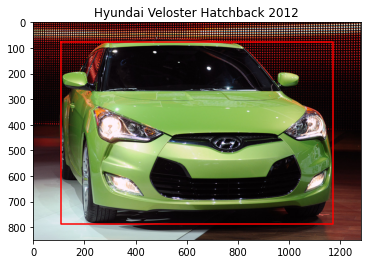

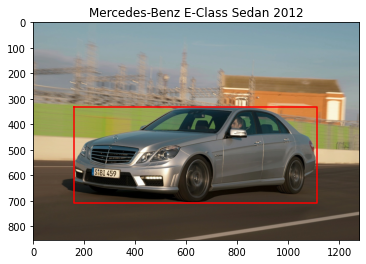

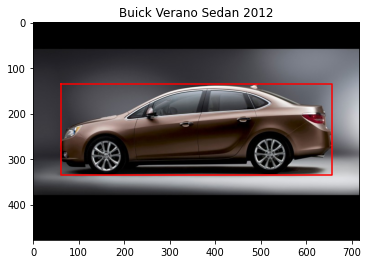

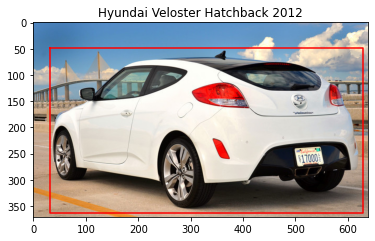

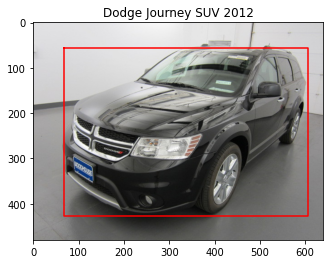

In [ ]:
for i in np.random.randint(0, len(train_list), 5):
    line = train_list[i][0].split(',')
    class_id = int(line[5]) - 1
    image = cv2.imread(line[0])
    plt.figure()
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(class_names[class_id])
    
    x1 = int(line[1])
    y1 = int(line[2])
    x2 = int(line[3])
    y2 = int(line[4])
    plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], 'r-')


### step #1: define Generator 

In [ ]:
class DataGenerator(keras.utils.Sequence):
  def __init__(self, data_list, batch_size, shuffle=True):
    self.data_list = data_list
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    return int(np.ceil(len(self.data_list) / self.batch_size))

  def __getitem__(self, idx):
    indexes = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size]

    X = []
    y = []
    for i in indexes:
      line = self.data_list[i][0].split(',')
      class_id = int(line[5]) - 1
      image = cv2.imread(line[0])

      resized_image = cv2.resize(image, (224, 224))
      X.append(resized_image)
      y.append(class_id)
    
    return np.array(X), np.array(y)
      

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.data_list))
    if self.shuffle:
      np.random.shuffle(self.indexes)

In [ ]:
BATCH_SIZE = 64
EVAL_BATCH_SIZE = BATCH_SIZE
train_generator = DataGenerator(train_list, BATCH_SIZE)
test_generator = DataGenerator(test_list, EVAL_BATCH_SIZE)

##### Tests

In [ ]:
print(len(train_generator))
print(len(test_generator))

128
126


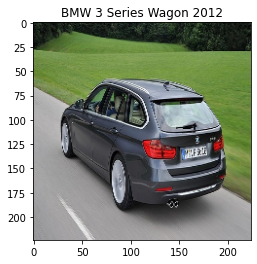

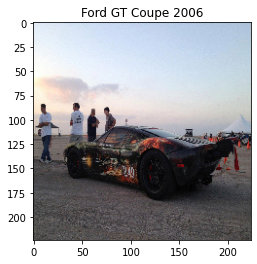

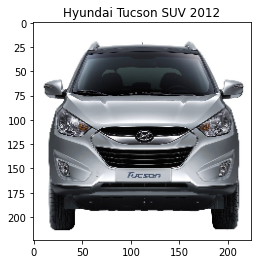

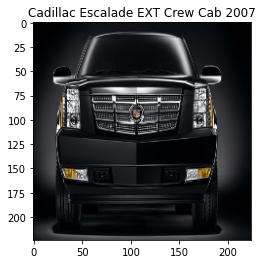

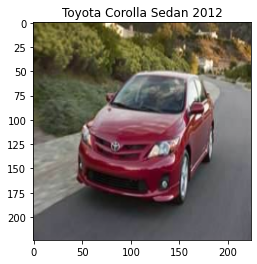

In [ ]:
for i in train_generator:
  for j in range(5):
    plt.figure()
    plt.imshow(cv2.cvtColor(i[0][j], cv2.COLOR_BGR2RGB))
    plt.title(class_names[i[1][j]])
  break

In [ ]:
for i in train_generator:
  print(i)
  print(i[0].shape, i[1].shape)
  break

(array([[[[ 20,  35,  23],
         [ 28,  40,  28],
         [ 37,  47,  34],
         ...,
         [ 38,  46,  36],
         [ 29,  40,  28],
         [ 20,  30,  18]],

        [[ 29,  39,  30],
         [ 30,  40,  29],
         [ 29,  37,  26],
         ...,
         [ 19,  26,  17],
         [ 30,  40,  29],
         [ 38,  48,  36]],

        [[ 21,  26,  22],
         [ 38,  43,  37],
         [ 21,  29,  19],
         ...,
         [ 26,  31,  25],
         [ 34,  41,  33],
         [ 20,  29,  19]],

        ...,

        [[152, 147, 148],
         [156, 151, 152],
         [153, 148, 148],
         ...,
         [162, 160, 160],
         [163, 161, 161],
         [166, 164, 164]],

        [[153, 148, 149],
         [154, 150, 151],
         [161, 156, 157],
         ...,
         [162, 160, 160],
         [162, 160, 160],
         [163, 161, 161]],

        [[152, 147, 148],
         [155, 150, 151],
         [159, 154, 155],
         ...,
         [167, 165, 165],
       

####  step #2 : train ResNet50 model on training data just for classification task (without augmentation and just use random weight) and evaluate on test data.


In [ ]:
model = keras.applications.ResNet50(input_shape=(224, 224, 3), classes=196, weights=None)
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
EPOCHS = 20
random_weights_history = model.fit(train_generator, epochs=EPOCHS, validation_data=test_generator)

Epoch 1/20
128/128 [==============================] - 166s 1s/step - loss: 6.0297 - sparse_categorical_accuracy: 0.0067 - val_loss: 5.3528 - val_sparse_categorical_accuracy: 0.0044
Epoch 2/20
128/128 [==============================] - 160s 1s/step - loss: 5.3223 - sparse_categorical_accuracy: 0.0083 - val_loss: 5.2447 - val_sparse_categorical_accuracy: 0.0132
Epoch 3/20
128/128 [==============================] - 142s 1s/step - loss: 5.1884 - sparse_categorical_accuracy: 0.0156 - val_loss: 20.3834 - val_sparse_categorical_accuracy: 0.0085
Epoch 4/20
128/128 [==============================] - 142s 1s/step - loss: 5.0974 - sparse_categorical_accuracy: 0.0168 - val_loss: 5.1520 - val_sparse_categorical_accuracy: 0.0206
Epoch 5/20
128/128 [==============================] - 142s 1s/step - loss: 5.0082 - sparse_categorical_accuracy: 0.0225 - val_loss: 7.4476 - val_sparse_categorical_accuracy: 0.0066
Epoch 6/20
128/128 [==============================] - 141s 1s/step - loss: 4.9042 - sparse_cat

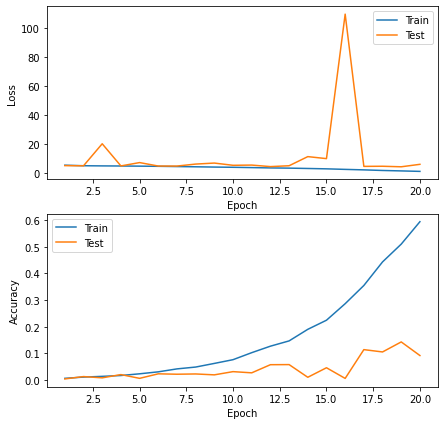

In [ ]:
plt.figure(figsize=(7, 7))
plt.subplot(2, 1, 1)
plt.plot(np.arange(1, EPOCHS + 1), random_weights_history.history['loss'], label='Train')
plt.plot(np.arange(1, EPOCHS + 1), random_weights_history.history['val_loss'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(np.arange(1, EPOCHS + 1), random_weights_history.history['sparse_categorical_accuracy'], label='Train')
plt.plot(np.arange(1, EPOCHS + 1), random_weights_history.history['val_sparse_categorical_accuracy'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### step #3 : train  ResNet50 model on Imagenet dataset just for classification task by Fine-Tuning (without augmentation and just use pretrain weight ) and evaluate on test data.

In [ ]:
model = keras.applications.ResNet50(input_shape=(224, 224, 3), classes=196, weights='imagenet', include_top=False)

### Freeze some layers
for i in range(100):
    model.layers[i].trainable=False

x = keras.layers.GlobalAvgPool2D()(model.output)
x = keras.layers.Dense(units=196, activation='softmax')(x)
model = keras.models.Model(model.input, x)
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.9,
                                             momentum=0.5),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
EPOCHS = 20
imagenet_weights_history = model.fit(train_generator, epochs=EPOCHS, validation_data=test_generator)

Epoch 1/20
128/128 [==============================] - 140s 1s/step - loss: 6.0696 - sparse_categorical_accuracy: 0.0068 - val_loss: 8.1745 - val_sparse_categorical_accuracy: 0.0092
Epoch 2/20
128/128 [==============================] - 135s 1s/step - loss: 5.1561 - sparse_categorical_accuracy: 0.0149 - val_loss: 6.7224 - val_sparse_categorical_accuracy: 0.0182
Epoch 3/20
128/128 [==============================] - 129s 1s/step - loss: 4.6355 - sparse_categorical_accuracy: 0.0320 - val_loss: 4.9505 - val_sparse_categorical_accuracy: 0.0340
Epoch 4/20
128/128 [==============================] - 128s 1s/step - loss: 4.1143 - sparse_categorical_accuracy: 0.0679 - val_loss: 5.1667 - val_sparse_categorical_accuracy: 0.0538
Epoch 5/20
128/128 [==============================] - 129s 1s/step - loss: 3.4238 - sparse_categorical_accuracy: 0.1463 - val_loss: 3.8869 - val_sparse_categorical_accuracy: 0.1346
Epoch 6/20
128/128 [==============================] - 129s 1s/step - loss: 2.4924 - sparse_cate

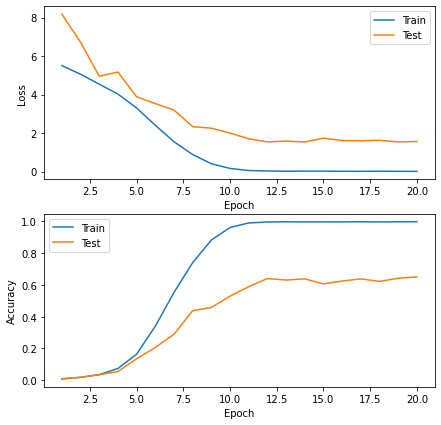

In [ ]:
plt.figure(figsize=(7, 7))
plt.subplot(2, 1, 1)
plt.plot(np.arange(1, EPOCHS + 1), imagenet_weights_history.history['loss'], label='Train')
plt.plot(np.arange(1, EPOCHS + 1), imagenet_weights_history.history['val_loss'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(np.arange(1, EPOCHS + 1), imagenet_weights_history.history['sparse_categorical_accuracy'], label='Train')
plt.plot(np.arange(1, EPOCHS + 1), imagenet_weights_history.history['val_sparse_categorical_accuracy'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### step #4 : train  ResNet50 model on Imagenet dataset just for classification task by Fine-Tuning ( use augmentation, pretrain weight, add Dropout layers ) and evaluate on test data.

In [ ]:
# @title Augmentor
from imgaug import augmenters as iaa

seq = iaa.Sequential([
      iaa.Fliplr(0.5), # horizontal flips
      iaa.Crop(percent=(0, 0.1)), # random crops
      # Small gaussian blur with random sigma between 0 and 0.5.
      # But we only blur about 50% of all images.
      iaa.Sometimes(
          0.5,
          iaa.GaussianBlur(sigma=(0, 0.5))
      ),
      # Strengthen or weaken the contrast in each image.
      iaa.LinearContrast((0.75, 1.5)),
      # Add gaussian noise.
      # For 50% of all images, we sample the noise once per pixel.
      # For the other 50% of all images, we sample the noise per pixel AND
      # channel. This can change the color (not only brightness) of the
      # pixels.
      iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
      # Make some images brighter and some darker.
      # In 20% of all cases, we sample the multiplier once per channel,
      # which can end up changing the color of the images.
      iaa.Multiply((0.8, 1.2), per_channel=0.2),
      # Apply affine transformations to each image.
      # Scale/zoom them, translate/move them, rotate them and shear them.
      iaa.Affine(
          scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
          translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
          rotate=(-10, 10),
          shear=(-5, 5)
      )
    ], random_order=True)

In [ ]:
class DataGeneratorWithAug(keras.utils.Sequence):
  def __init__(self, data_list, batch_size, aug_rate, aug_seq, shuffle=True):
    self.data_list = data_list
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.aug_rate = int(aug_rate)
    self.on_epoch_end()
    self.aug_seq = aug_seq

  def __len__(self):
    self.orig_len = int(np.ceil(len(self.data_list) / self.batch_size))
    return self.orig_len * self.aug_rate

  def __getitem__(self, idx):
    idx = idx % self.orig_len
    indexes = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size]

    X = []
    y = []
    for i in indexes:
      line = self.data_list[i][0].split(',')
      class_id = int(line[5]) - 1
      image = cv2.imread(line[0])

      resized_image = cv2.resize(image, (224, 224))

      X.append(resized_image)
      y.append(class_id)
    
    return self.aug_seq(images=np.array(X)), np.array(y)
      

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.data_list))
    if self.shuffle:
      np.random.shuffle(self.indexes)

In [ ]:
train_generator = DataGeneratorWithAug(train_list, BATCH_SIZE, aug_rate=3, aug_seq=seq)

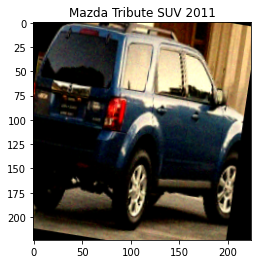

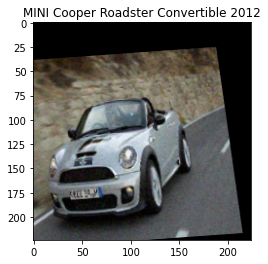

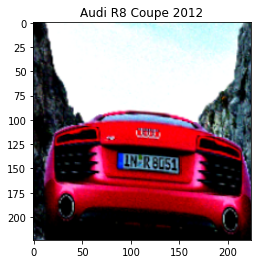

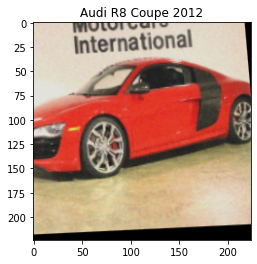

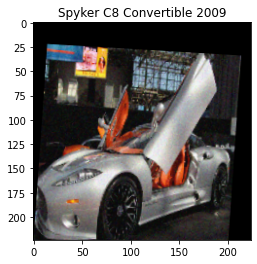

In [ ]:
for i in train_generator:
  for j in range(5):
    plt.figure()
    plt.imshow(cv2.cvtColor(i[0][j], cv2.COLOR_BGR2RGB))
    plt.title(class_names[i[1][j]])
  break

In [ ]:
model = keras.applications.ResNet50(input_shape=(224, 224, 3), classes=196, weights='imagenet', include_top=False)

### Freeze some layers
for i in range(100):
    model.layers[i].trainable=False

x = keras.layers.GlobalAvgPool2D()(model.output)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(units=196, activation='softmax')(x)
model = keras.models.Model(model.input, x)
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.9,
                                             momentum=0.5),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
EPOCHS = 20

imagenet_wAug_weights_history = model.fit(train_generator, epochs=EPOCHS, validation_data=test_generator)

Epoch 1/20
384/384 [==============================] - 456s 1s/step - loss: 6.2124 - sparse_categorical_accuracy: 0.0077 - val_loss: 4.8195 - val_sparse_categorical_accuracy: 0.0276
Epoch 2/20
384/384 [==============================] - 441s 1s/step - loss: 4.5302 - sparse_categorical_accuracy: 0.0485 - val_loss: 5.1259 - val_sparse_categorical_accuracy: 0.0866
Epoch 3/20
384/384 [==============================] - 442s 1s/step - loss: 2.9830 - sparse_categorical_accuracy: 0.2610 - val_loss: 2.3070 - val_sparse_categorical_accuracy: 0.4024
Epoch 4/20
384/384 [==============================] - 440s 1s/step - loss: 1.6434 - sparse_categorical_accuracy: 0.5444 - val_loss: 1.5407 - val_sparse_categorical_accuracy: 0.5795
Epoch 5/20
384/384 [==============================] - 441s 1s/step - loss: 0.9698 - sparse_categorical_accuracy: 0.7129 - val_loss: 1.7003 - val_sparse_categorical_accuracy: 0.5872
Epoch 6/20
384/384 [==============================] - 441s 1s/step - loss: 0.6059 - sparse_cate

KeyboardInterrupt: ignored

In [ ]:
plt.figure(figsize=(7, 7))
plt.subplot(2, 1, 1)
plt.plot(np.arange(1, EPOCHS + 1), imagenet_wAug_weights_history.history['loss'], label='Train')
plt.plot(np.arange(1, EPOCHS + 1), imagenet_wAug_weights_history.history['val_loss'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(np.arange(1, EPOCHS + 1), imagenet_wAug_weights_history.history['sparse_categorical_accuracy'], label='Train')
plt.plot(np.arange(1, EPOCHS + 1), imagenet_wAug_weights_history.history['val_sparse_categorical_accuracy'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##### modify Generator according classification and localization tasks

In [ ]:
class DataGeneratorWBB(keras.utils.Sequence):
  def __init__(self, data_list, batch_size, shuffle=True):
    self.data_list = data_list
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    return int(np.ceil(len(self.data_list) / self.batch_size))

  def __getitem__(self, idx):
    indexes = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size]

    X = []
    y = []
    bounding_boxes = []
    for i in indexes:
      line = self.data_list[i][0].split(',')
      class_id = int(line[5]) - 1
      image = cv2.imread(line[0])
      scale_x = 224. / image.shape[1]
      scale_y = 224. / image.shape[0]

      x1 = int(line[1]) * scale_x
      y1 = int(line[2]) * scale_y
      x2 = int(line[3]) * scale_x
      y2 = int(line[4]) * scale_y

      resized_image = cv2.resize(image, (224, 224))
      X.append(resized_image)
      y.append(class_id)
      bounding_boxes.append([x1, y1, x2, y2])
    
    return np.array(X), {'label': np.array(y), 'bbox': np.array(bounding_boxes, dtype=np.int)}
      
  def on_epoch_end(self):
    self.indexes = np.arange(len(self.data_list))
    if self.shuffle:
      np.random.shuffle(self.indexes)

In [ ]:
test_generator = DataGeneratorWBB(test_list, EVAL_BATCH_SIZE)

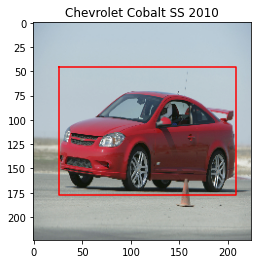

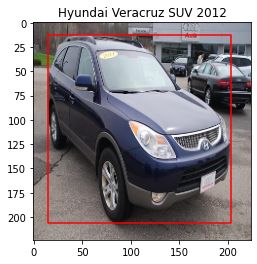

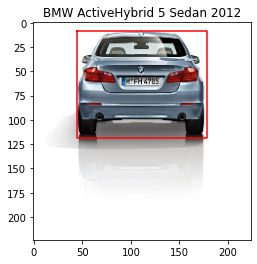

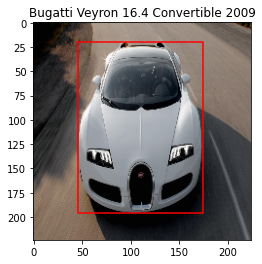

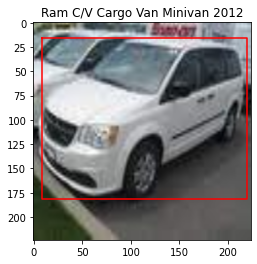

In [ ]:
for i in test_generator:
  for j in range(5):
    plt.figure()
    plt.imshow(cv2.cvtColor(i[0][j], cv2.COLOR_BGR2RGB))
    plt.title(class_names[i[1]["label"][j]])

    x1 = int(i[1]["bbox"][j, 0])
    y1 = int(i[1]["bbox"][j, 1])
    x2 = int(i[1]["bbox"][j, 2])
    y2 = int(i[1]["bbox"][j, 3])
    plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], 'r-')
  break

### step #5 : train  ResNet50 model on Imagenet dataset for classification  and localization task by Fine-Tuning ( use augmentation, pretrain weight, add Dropout layers ) and evaluate on test data.

In [ ]:
from imgaug.augmentables.bbs import BoundingBox

class DataGeneratorWBBandAug(keras.utils.Sequence):
  def __init__(self, data_list, batch_size, aug_rate, aug_seq, shuffle=True):
    self.data_list = data_list
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.aug_rate = aug_rate
    self.aug_seq = aug_seq
    self.on_epoch_end()

  def __len__(self):
    self.orig_len = int(np.ceil(len(self.data_list) / self.batch_size))
    return self.orig_len * self.aug_rate

  def __getitem__(self, idx):
    idx = idx % self.orig_len
    indexes = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size]

    X = []
    y = []
    bounding_boxes = []
    for i in indexes:
      line = self.data_list[i][0].split(',')
      class_id = int(line[5]) - 1
      image = cv2.imread(line[0])
      
      scale_x = 224. / image.shape[1]
      scale_y = 224. / image.shape[0]

      x1 = int(line[1]) * scale_x
      y1 = int(line[2]) * scale_y
      x2 = int(line[3]) * scale_x
      y2 = int(line[4]) * scale_y

      resized_image = cv2.resize(image, (224, 224))
      aug_img, aug_bb = self.aug_seq(image=resized_image, bounding_boxes=BoundingBox(x1=x1, x2=x2, y1=y1, y2=y2))

      X.append(aug_img)
      y.append(class_id)
      bounding_boxes.append([aug_bb.x1, aug_bb.y1, aug_bb.x2, aug_bb.y2])
    
    
    return np.array(X), {'label': np.array(y), 'bbox': np.array(bounding_boxes)}
      
  def on_epoch_end(self):
    self.indexes = np.arange(len(self.data_list))
    if self.shuffle:
      np.random.shuffle(self.indexes)

In [ ]:
train_generator = DataGeneratorWBBandAug(train_list, BATCH_SIZE, aug_seq=seq, aug_rate=2)

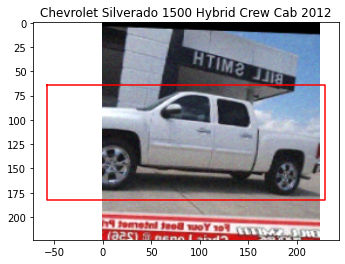

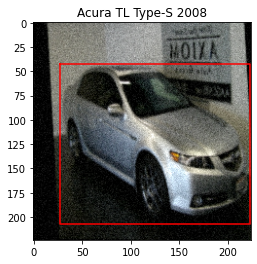

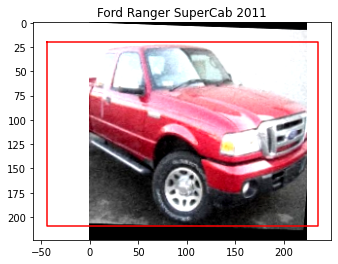

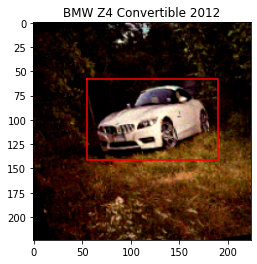

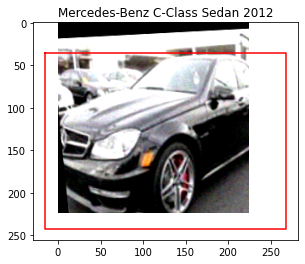

In [ ]:
for i in train_generator:
  for j in range(5):
    plt.figure()
    plt.imshow(cv2.cvtColor(i[0][j], cv2.COLOR_BGR2RGB))
    plt.title(class_names[i[1]["label"][j]])

    x1 = int(i[1]["bbox"][j, 0])
    y1 = int(i[1]["bbox"][j, 1])
    x2 = int(i[1]["bbox"][j, 2])
    y2 = int(i[1]["bbox"][j, 3])
    plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], 'r-')
  break

In [ ]:
model = keras.applications.ResNet50(input_shape=(224, 224, 3), classes=196, weights='imagenet', include_top=False)

x = keras.layers.GlobalAvgPool2D()(model.output)
x = keras.layers.Dropout(0.3)(x)

class_output = keras.layers.Dense(units=196, activation='softmax', name='label')(x)
box_output = keras.layers.Dense(units=4, name='bbox')(x)

model = keras.models.Model(model.input, {'label': class_output, 'bbox': box_output})

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005),
              loss={'label':  keras.losses.SparseCategoricalCrossentropy(),
                    'bbox': keras.losses.MeanSquaredError()},
              metrics={'label':  keras.metrics.SparseCategoricalAccuracy(),
                       'bbox': keras.metrics.MeanAbsoluteError()},
              loss_weights={'label': 1,
                            'bbox': 0.001})

In [ ]:
EPOCHS = 20

imagenet_wAug_weights_history = model.fit(train_generator, epochs=EPOCHS, validation_data=test_generator)

Epoch 1/20
256/256 [==============================] - 644s 2s/step - loss: 14.7604 - bbox_loss: 7470.7859 - label_loss: 7.2896 - bbox_mean_absolute_error: 55.3378 - label_sparse_categorical_accuracy: 0.0076 - val_loss: 11.4301 - val_bbox_loss: 4877.1646 - val_label_loss: 6.5529 - val_bbox_mean_absolute_error: 55.5268 - val_label_sparse_categorical_accuracy: 0.0080
Epoch 2/20
256/256 [==============================] - 575s 2s/step - loss: 6.8214 - bbox_loss: 935.6302 - label_loss: 5.8858 - bbox_mean_absolute_error: 24.1323 - label_sparse_categorical_accuracy: 0.0082 - val_loss: 7.8657 - val_bbox_loss: 1317.7449 - val_label_loss: 6.5480 - val_bbox_mean_absolute_error: 28.3316 - val_label_sparse_categorical_accuracy: 0.0078
Epoch 3/20
256/256 [==============================] - 574s 2s/step - loss: 6.5713 - bbox_loss: 897.7347 - label_loss: 5.6736 - bbox_mean_absolute_error: 23.6239 - label_sparse_categorical_accuracy: 0.0086 - val_loss: 6.4501 - val_bbox_loss: 694.3596 - val_label_loss: 5

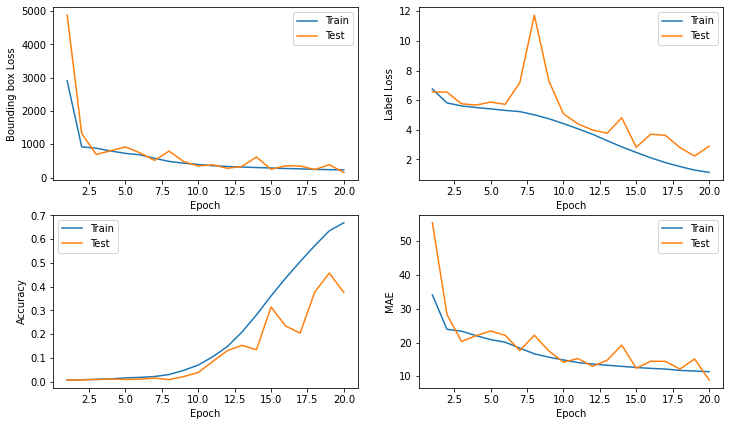

In [ ]:
plt.figure(figsize=(12, 7))
plt.subplot(2, 2, 1)
plt.plot(np.arange(1, EPOCHS + 1), imagenet_wAug_weights_history.history['bbox_loss'], label='Train')
plt.plot(np.arange(1, EPOCHS + 1), imagenet_wAug_weights_history.history['val_bbox_loss'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Bounding box Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(np.arange(1, EPOCHS + 1), imagenet_wAug_weights_history.history['label_loss'], label='Train')
plt.plot(np.arange(1, EPOCHS + 1), imagenet_wAug_weights_history.history['val_label_loss'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Label Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(np.arange(1, EPOCHS + 1), imagenet_wAug_weights_history.history['label_sparse_categorical_accuracy'], label='Train')
plt.plot(np.arange(1, EPOCHS + 1), imagenet_wAug_weights_history.history['val_label_sparse_categorical_accuracy'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(np.arange(1, EPOCHS + 1), imagenet_wAug_weights_history.history['bbox_mean_absolute_error'], label='Train')
plt.plot(np.arange(1, EPOCHS + 1), imagenet_wAug_weights_history.history['val_bbox_mean_absolute_error'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [ ]:
EPOCHS = 10

model.fit(train_generator, epochs=EPOCHS, validation_data=test_generator)

Epoch 1/10
256/256 [==============================] - 580s 2s/step - loss: 1.1710 - bbox_loss: 222.7959 - label_loss: 0.9482 - bbox_mean_absolute_error: 11.1776 - label_sparse_categorical_accuracy: 0.7195 - val_loss: 2.1251 - val_bbox_loss: 171.4566 - val_label_loss: 1.9537 - val_bbox_mean_absolute_error: 9.8617 - val_label_sparse_categorical_accuracy: 0.5282
Epoch 2/10
256/256 [==============================] - 575s 2s/step - loss: 1.0851 - bbox_loss: 218.9713 - label_loss: 0.8661 - bbox_mean_absolute_error: 11.0697 - label_sparse_categorical_accuracy: 0.7372 - val_loss: 2.3429 - val_bbox_loss: 142.3051 - val_label_loss: 2.2006 - val_bbox_mean_absolute_error: 9.0441 - val_label_sparse_categorical_accuracy: 0.4846
Epoch 3/10
256/256 [==============================] - 573s 2s/step - loss: 0.9502 - bbox_loss: 207.8370 - label_loss: 0.7424 - bbox_mean_absolute_error: 10.8428 - label_sparse_categorical_accuracy: 0.7742 - val_loss: 2.4805 - val_bbox_loss: 132.9050 - val_label_loss: 2.3476 -

KeyboardInterrupt: ignored

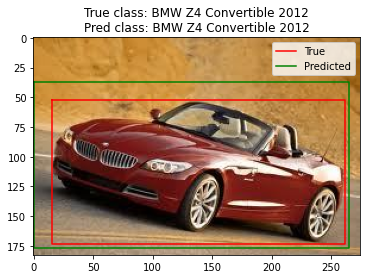

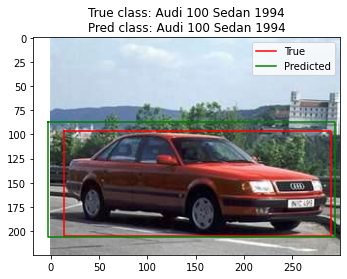

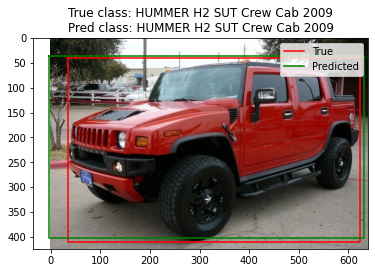

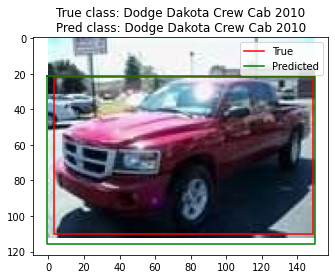

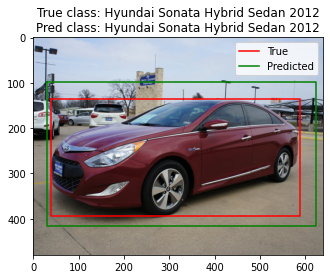

In [ ]:
for i in np.random.randint(0, len(train_list), 5):
  line = train_list[i][0].split(',')
  label_true = int(line[5]) - 1
  
  image = cv2.imread('/content/' + line[0])

  outputs = model.predict(np.array([cv2.resize(image, (224, 224))]))
  class_id_pred = np.argmax(outputs['label'][0])

  plt.figure()
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.title("True class: " + class_names[label_true] + "\n" + "Pred class: " + class_names[class_id_pred])
  
  x1_true = int(line[1])
  y1_true = int(line[2])
  x2_true = int(line[3])
  y2_true = int(line[4])
  plt.plot([x1_true, x1_true, x2_true, x2_true, x1_true], [y1_true, y2_true, y2_true, y1_true, y1_true], 'r-', label='True')

  image_height_scale = image.shape[0] / 224
  image_width_scale = image.shape[1] / 224
  x1_pred = int(outputs['bbox'][0][0] * image_width_scale)
  y1_pred = int(outputs['bbox'][0][1] * image_height_scale)
  x2_pred = int(outputs['bbox'][0][2] * image_width_scale)
  y2_pred = int(outputs['bbox'][0][3] * image_height_scale)
  plt.plot([x1_pred, x1_pred, x2_pred, x2_pred, x1_pred], [y1_pred, y2_pred, y2_pred, y1_pred, y1_pred], 'g-', label='Predicted')
  plt.legend(loc='upper right')
  plt.show()

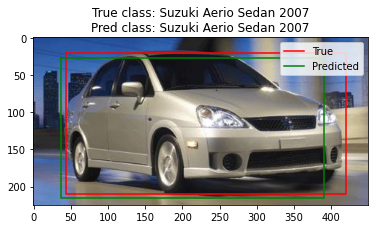

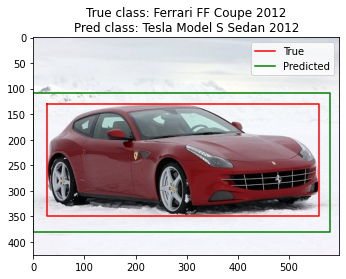

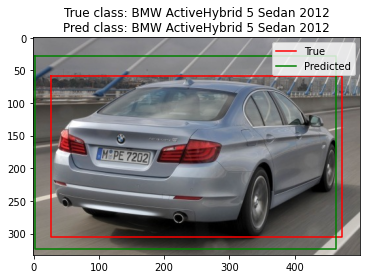

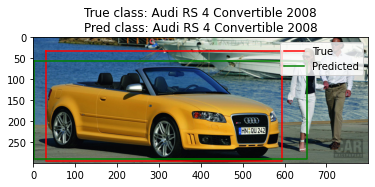

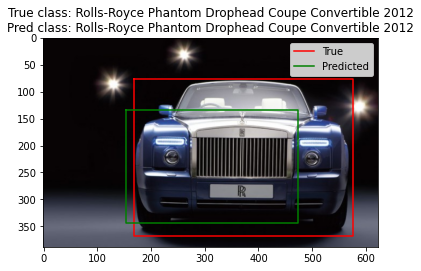

In [ ]:
for i in np.random.randint(0, len(train_list), 5):
  line = train_list[i][0].split(',')
  label_true = int(line[5]) - 1
  
  image = cv2.imread('/content/' + line[0])

  outputs = model.predict(np.array([cv2.resize(image, (224, 224))]))
  class_id_pred = np.argmax(outputs['label'][0])

  plt.figure()
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.title("True class: " + class_names[label_true] + "\n" + "Pred class: " + class_names[class_id_pred])
  
  x1_true = int(line[1])
  y1_true = int(line[2])
  x2_true = int(line[3])
  y2_true = int(line[4])
  plt.plot([x1_true, x1_true, x2_true, x2_true, x1_true], [y1_true, y2_true, y2_true, y1_true, y1_true], 'r-', label='True')

  image_height_scale = image.shape[0] / 224
  image_width_scale = image.shape[1] / 224
  x1_pred = int(outputs['bbox'][0][0] * image_width_scale)
  y1_pred = int(outputs['bbox'][0][1] * image_height_scale)
  x2_pred = int(outputs['bbox'][0][2] * image_width_scale)
  y2_pred = int(outputs['bbox'][0][3] * image_height_scale)
  plt.plot([x1_pred, x1_pred, x2_pred, x2_pred, x1_pred], [y1_pred, y2_pred, y2_pred, y1_pred, y1_pred], 'g-', label='Predicted')
  plt.legend(loc='upper right')
  plt.show()